# Enumerate cluster sizes 

When you observe a host transition from one deme to the next, how many tips are included in that cluster? Does this vary by host group? Let's find out!

In [1]:
import glob
import re,copy, imp
import pandas as pd 
import numpy as np

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '/Users/lmoncla/src/baltic/baltic/baltic.py')

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

import time
from io import StringIO

import rpy2
%load_ext rpy2.ipython

In [2]:
from datetime import date
current_date = str(date.today())

In [3]:
# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

In [4]:
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 22})

In [5]:
# tree_paths
constant_human_on = ""
constant_human_off = {"label": "constant-human-off",
    "tree":"beast-runs/2021-03-15-mascot-3deme-constant/no-human-mig/2021-03-15-mascot-3deme-constant-human-off.combined.mcc.tree"}
skyline_human_on =  ""
skyline_human_off = {"label": "skyline-human-off", 
                     "mcc_tree": "beast-runs/2021-07-26-mascot-3deme-skyline-with-mig-fixed-log/with-extra-logger/combined-trees-2021-08-23.mcc.tree",
                    "posterior_trees": "beast-runs/2021-07-26-mascot-3deme-skyline-with-mig-fixed-log/with-extra-logger/combined-trees-file-2021-08-23.trees"}

In [6]:
# read in tree
to_run = skyline_human_off

mcc_tree = bt.loadNexus(to_run['mcc_tree'])
label = to_run['label']

In [7]:
for k in mcc_tree.Objects: 
    if k.branchType == "node":
        #print(k.parent.traits)
        pass

## Enumerate subtrees and plot

In [8]:
"""enumerate host transitions on the tree"""

def retrieve_subtrees(tree, trait):
    
    traitName=trait

    tree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    tree_strings={host:[] for host in hosts_list}
    subtype_trees={host:[] for host in hosts_list}

    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k

        ## get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName].lower().replace(" ","_")   # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:  # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName].lower().replace(" ","_")     # kploc = trait of parental node
        else:
            kploc='ancestor'

        ## if states do not match
        if kloc!=kploc:      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName].lower().replace(" ","_")==kloc     # traverse tree for all nodes whose traitname = kc
            #print('subtree resulting from '+kploc+' > '+kloc+' switch, traversing within '+ kloc)

            subtree=tree.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
            
            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()
                if kloc in subtype_trees:
                    subtype_trees[kloc].append((kploc,subtree))
                else:
                    pass
                    #print(kloc, " not in countries list")
                    
    return(subtype_trees)

In [9]:
hosts_list = ['human','wild','domestic']
trait = 'max'

subtype_trees = retrieve_subtrees(mcc_tree, trait)

## Evaluate cluster sizes and time of circulation

In [10]:
def infer_large_clusters(subtype_trees, cutoff_value):
    large_clusters = {}
    
    for deme in subtype_trees: 
        large_clusters[deme] = []
        
        for subtree in subtype_trees[deme]:
            trans_from = subtree[0]
            tree = subtree[1]
            number_tips = 0
            for k in tree.Objects: 
                if k.branchType == "leaf":
                    number_tips += 1
            #total_tips = tree.root.leaves  # leaves is the total # descendant tips, children is just the immediate descendants
            if number_tips > cutoff_value:
                to_add = (trans_from,tree)
                large_clusters[deme].append(to_add)

    return(large_clusters)

In [11]:
# characterize introduction sizes
def output_cluster_sizes(subtype_trees):
    cluster_sizes = {}
    
    for deme in subtype_trees: 
        cluster_sizes[deme] = {}
        
        for subtree in subtype_trees[deme]:
            trans_from = subtree[0]
            tree = subtree[1]
            number_tips = 0
            for k in tree.Objects: 
                if k.branchType == "leaf":
                    number_tips += 1
            #total_tips = tree.root.leaves  # leaves is the total # descendant tips, children is just the immediate descendants
            if number_tips in cluster_sizes[deme]:
                cluster_sizes[deme][number_tips] += 1
            else:
                cluster_sizes[deme][number_tips] = 1

    return(cluster_sizes)

In [12]:
def output_cluster_times(subtype_trees):
    cluster_times = {}
    
    for deme in subtype_trees: 
        cluster_times[deme] = []
        
        for subtree in subtype_trees[deme]:
            dates = []
            trans_from = subtree[0]
            tree = subtree[1]
            
            for k in tree.Objects: 
                if k.branchType == "leaf":
                    # pull the date
                    date = float(k.name.split("|")[1])
                elif k.branchType == "node":
                    date = k.absoluteTime
                dates.append(date)
                
            minimum_date = min(dates)
            maximum_date = max(dates)
            date_range = maximum_date - minimum_date
            
            cluster_times[deme].append(date_range)

    return(cluster_times)

In [13]:
cutoff_value = 1
large_clusters = infer_large_clusters(subtype_trees, cutoff_value)
# large_clusters

In [14]:
cluster_times_dict = output_cluster_times(subtype_trees)
cluster_times_dict

{'human': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.5934051918272871,
  0.0,
  0.0,
  0.5848638580766874,
  0.24997355693790269,
  1.59699999999998,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.44574727872600306,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.34450253069871906,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.6420449947638645,
  0.0,
  0.0,
  0.0,
  0.4059323402736936,
  0.0,
  1.1557581939243846,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.4207589496372748,
  0.0,
  0.0,
  0.0],
 'wild': [20.06870193967484,
  2.062409903041271,
  0.0

In [15]:
cluster_times_df = pd.DataFrame()

for deme in cluster_times_dict:
    local_df = pd.DataFrame.from_dict({"deme":deme, "circulation_time":cluster_times_dict[deme]})
    cluster_times_df = cluster_times_df.append(local_df)
    
cluster_times_df.head()

,deme,circulation_time
0,human,0.0
1,human,0.0
2,human,0.0
3,human,0.0
4,human,0.0


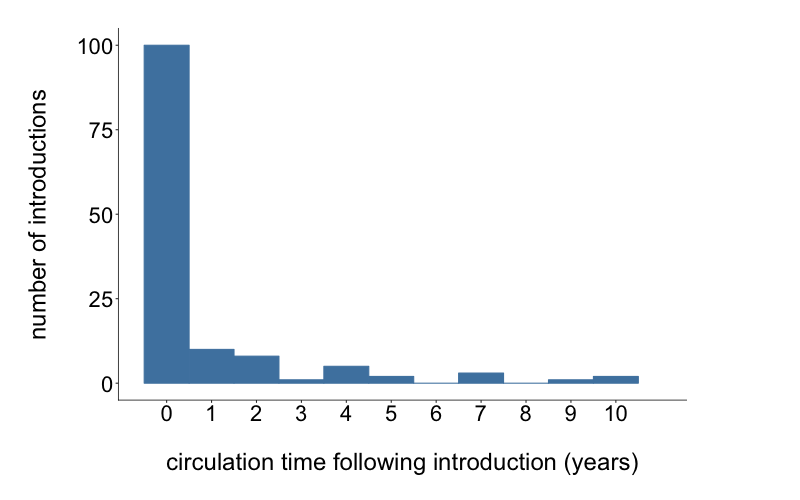

In [25]:
%%R -w 800 -h 500 -u px -i current_date,label,cluster_times_df,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("cluster-times-hist-",label,"-",current_date,".pdf", sep="")
cluster_times_df <- cluster_times_df[(cluster_times_df$deme == "domestic"),]

p <- ggplot(data=cluster_times_df, aes(x=circulation_time)) + 
    geom_histogram(binwidth=1, color=domestic_color, fill=domestic_color)+
    #geom_hline(yintercept=1, linetype=3)+
    labs(y="number of introductions\n",x="\ncirculation time following introduction (years)")+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    scale_x_continuous(breaks=seq(0,10,1), limits=c(-0.5,11))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 8, height = 5, device = "pdf", path = "figures", dpi = 300)
p

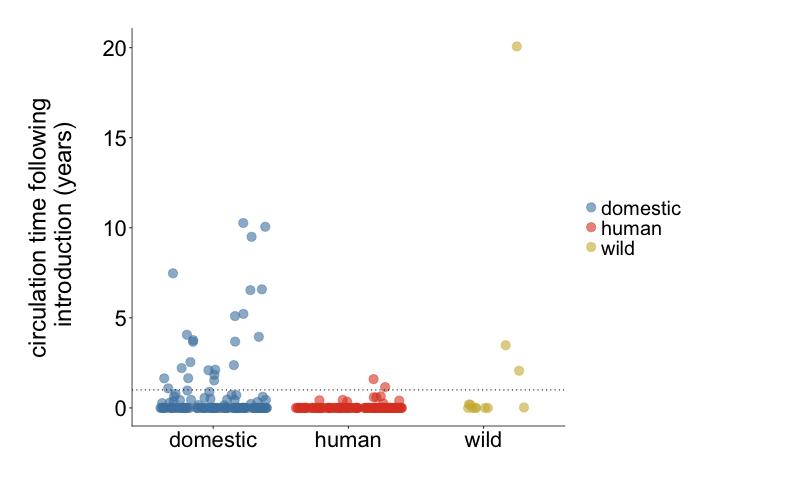

In [88]:
%%R -w 800 -h 500 -u px -i current_date,label,cluster_times_df,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("cluster-times-",label,"-",current_date,".pdf", sep="")

p <- ggplot(data=cluster_times_df, aes(x=deme, y=circulation_time, color=deme)) + 
    geom_jitter(alpha=0.6, size=4)+
    geom_hline(yintercept=1, linetype=3)+
    labs(x="",y="circulation time following\n introduction (years)\n")+
    scale_color_manual(values=c(human=human_color,wild=wild_color,domestic=domestic_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
#     scale_x_continuous(breaks=seq(0,1,0.2), limits=c(-0.05,1.0))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 12, height = 5, device = "pdf", path = "figures", dpi = 300)
p

## Cluster sizes on mcc tree and across the posterior

In [26]:
def get_taxa_lines(tree_path):    

    lines_to_write = ""
    with open(tree_path, 'rU') as infile:
        for line in infile: ## iterate through each line
            if 'state' not in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                lines_to_write = lines_to_write + line

    return(lines_to_write)

In [27]:
def get_burnin_value(tree_path, burnin_percent):
    with open(tree_path, 'rU') as infile:
        numtrees = 0
        for line in infile: ## iterate through each line
            if 'state' in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                numtrees += 1
    
    burnin = numtrees * burnin_percent
    return(burnin)

In [54]:
trees_file_path = to_run['posterior_trees']
label = to_run['label']
trait = 'max'

burnin_percent = 0

In [55]:
all_trees = trees_file_path
burnin_percent = 0

taxa_lines = get_taxa_lines(all_trees)
burnin = get_burnin_value(all_trees, burnin_percent)
print(burnin)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 'U' mode is deprecated
  after removing the cwd from sys.path.
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 'U' mode is deprecated
  


0


In [59]:
start_time = time.time()

with open(all_trees, "r") as infile:
    
    tree_counter = 0
    trees_processed = 0
    
    for line in infile:
        if 'tree STATE_' in line:
            tree_counter += 1
            
            if tree_counter < 3:
                trees_processed += 1
                temp_tree = StringIO(taxa_lines + line)
                tree = bt.loadNexus(temp_tree)
                tree.setAbsoluteTime(2019.227)
                
                # run stuff
                subtype_trees = retrieve_subtrees(tree, trait)
                cluster_sizes_dict = output_cluster_sizes(subtype_trees)
                
                local_dict[trees_processed] = cluster_sizes_dict

# print the amount of time this took
total_time_seconds = time.time() - start_time
total_time_minutes = total_time_seconds/60
print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes) to run on", trees_processed, "trees")

this took 26.054715871810913 seconds ( 0.43424526453018186  minutes) to run on 2 trees


In [60]:
local_dict

{4: {'human': {1: 95, 2: 11, 5: 1, 3: 1},
  'wild': {89: 1, 2: 1},
  'domestic': {1: 125,
   12: 1,
   22: 1,
   16: 1,
   47: 1,
   13: 1,
   8: 3,
   3: 5,
   2: 10,
   6: 1,
   5: 1,
   10: 1,
   7: 2,
   4: 1}},
 1: {'human': {1: 90, 3: 2, 2: 12, 5: 1},
  'wild': {28: 1, 1: 15, 8: 1, 17: 1, 9: 1, 12: 1, 2: 1},
  'domestic': {1: 81,
   12: 1,
   23: 1,
   16: 2,
   6: 2,
   10: 2,
   3: 4,
   2: 10,
   47: 1,
   13: 1,
   11: 1,
   21: 1,
   4: 4,
   5: 1,
   8: 1}},
 2: {'human': {1: 90, 3: 4, 2: 9, 5: 1},
  'wild': {87: 1, 1: 2, 2: 1},
  'domestic': {1: 102,
   12: 1,
   22: 1,
   16: 1,
   9: 1,
   47: 1,
   13: 1,
   3: 8,
   2: 14,
   8: 2,
   6: 2,
   5: 2,
   10: 1,
   4: 3}}}

### mcc tree

In [28]:
subtype_trees = retrieve_subtrees(mcc_tree, 'max')
cluster_sizes_dict = output_cluster_sizes(subtype_trees)

In [29]:
cluster_sizes_dict = output_cluster_sizes(subtype_trees)
cluster_sizes_dict

{'human': {1: 102, 2: 9, 5: 1},
 'wild': {63: 1, 9: 2, 1: 8, 2: 1},
 'domestic': {1: 93,
  2: 19,
  12: 1,
  23: 1,
  6: 1,
  7: 2,
  16: 1,
  47: 1,
  3: 5,
  13: 1,
  11: 1,
  15: 1,
  4: 3,
  10: 1,
  8: 1}}

In [30]:
cluster_sizes_df = pd.DataFrame()

for deme in cluster_sizes_dict:
    for cluster_size in cluster_sizes_dict[deme]:
        local_df = pd.DataFrame.from_dict({"deme":deme, "number_of_clusters":int(cluster_sizes_dict[deme][cluster_size]), 
                                           "cluster_size":[int(cluster_size)]})
        cluster_sizes_df = cluster_sizes_df.append(local_df)
    
cluster_sizes_df.head()

,deme,number_of_clusters,cluster_size
0,human,102,1
0,human,9,2
0,human,1,5
0,wild,1,63
0,wild,2,9


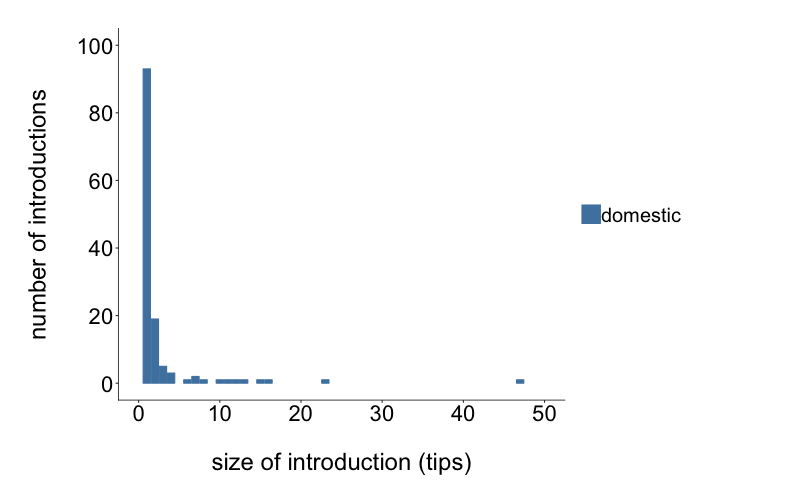

In [31]:
%%R -w 800 -h 500 -u px -i current_date,label,cluster_sizes_df,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("cluster-sizes-domestic-",label,"-",current_date,".pdf", sep="")
cluster_sizes_df <- cluster_sizes_df[(cluster_sizes_df$deme == "domestic"),]

p <- ggplot(data=cluster_sizes_df, aes(x=cluster_size, y=number_of_clusters, color=deme, fill=deme)) + 
    geom_col(position="dodge")+
    labs(x="\nsize of introduction (tips)",y="number of introductions\n")+
    scale_color_manual(values=c(human=human_color,wild=wild_color,domestic=domestic_color))+
    scale_fill_manual(values=c(human=human_color,wild=wild_color,domestic=domestic_color))+
    scale_y_continuous(breaks=seq(0,100,20), limits=c(0,100))+
    scale_x_continuous(breaks=seq(0,50,10), limits=c(0,50))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 5, device = "pdf", path = "figures", dpi = 300)
p

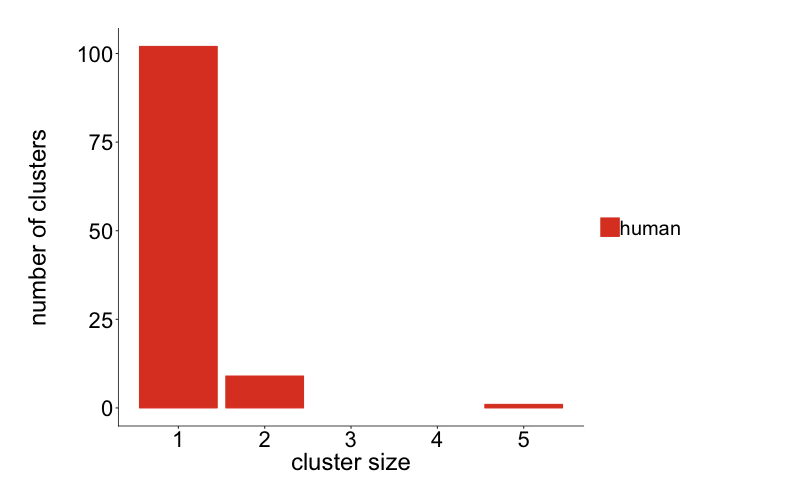

In [36]:
%%R -w 800 -h 500 -u px -i current_date,label,cluster_sizes_df,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("cluster-sizes-human-",label,"-",current_date,".pdf", sep="")
cluster_sizes_df <- cluster_sizes_df[(cluster_sizes_df$deme == "human"),]

p <- ggplot(data=cluster_sizes_df, aes(x=cluster_size, y=number_of_clusters, color=deme, fill=deme)) + 
    geom_col(position="dodge")+
    labs(x="cluster size",y="number of clusters\n")+
    scale_color_manual(values=c(human=human_color,wild=wild_color,domestic=domestic_color))+
    scale_fill_manual(values=c(human=human_color,wild=wild_color,domestic=domestic_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
#     scale_x_continuous(breaks=seq(0,1,0.2), limits=c(-0.05,1.0))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 12, height = 5, device = "pdf", path = "figures", dpi = 300)
p